In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Performance Metrics

In [3]:
from tensorflow.keras.datasets import mnist
from sklearn.linear_model import SGDClassifier

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Binary classifier

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5[0:5]

array([ True, False, False, False, False])

In [7]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
sgd_clf.predict([x_train[0]])

array([ True])

### K-Fold CV

Simple application of function:

In [11]:
from sklearn.model_selection import cross_val_score

In [9]:
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.9748, 0.9657, 0.9692])

Implementing cross validation:

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [11]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9748
0.9657
0.9692


### Confusion Matrix

TN  FP

FN  TP

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [13]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [14]:
y_train_pred[:5]

array([ True, False, False, False, False])

In [15]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53613,   966],
       [  840,  4581]], dtype=int64)

In [16]:
tn = cm[0,0]
fn = cm[1,0]
fp = cm[0,1]
tp = cm[1,1]

### Precision and Recall

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [18]:
precision_score(y_train_5, y_train_pred)

0.8258518117901569

In [19]:
tp / (tp + fp)

0.8258518117901569

In [20]:
recall_score(y_train_5, y_train_pred)

0.8450470392916436

In [21]:
tp / (tp + fn)

0.8450470392916436

In [22]:
f1_score(y_train_5, y_train_pred)

0.8353391684901532

In [23]:
tp / (tp + (fn + fp) / 2)

0.8353391684901532

In [24]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
                             method="decision_function")
y_scores[0:5]

array([ 1.65073246, -5.94781643, -8.22853161, -4.74258989, -5.8006586 ])

In [25]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center left", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-18, 10, 0, 1])

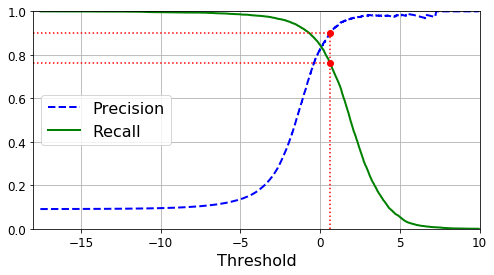

In [27]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([-18, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-18, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

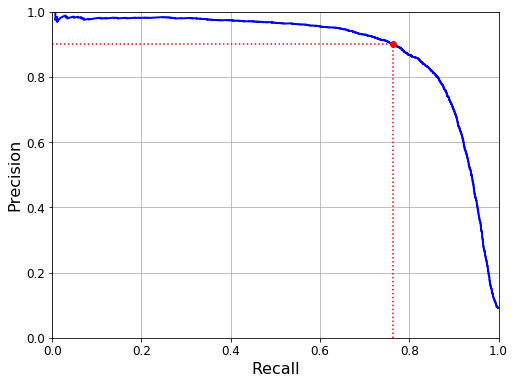

In [29]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [30]:
threshold_90_precision

0.6060137354660038

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9001305483028721

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.7631433314886552

### The ROC (Receiver Operating Characteristic) Curve

plots the true positive rate (recall) against the false positive rate (the ratio of negative instances incorrectly classified as positive).

True negative rate (TNR, specificity) is the ratio of negative instances that are correctly classified as negative.
Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

In [35]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True) 

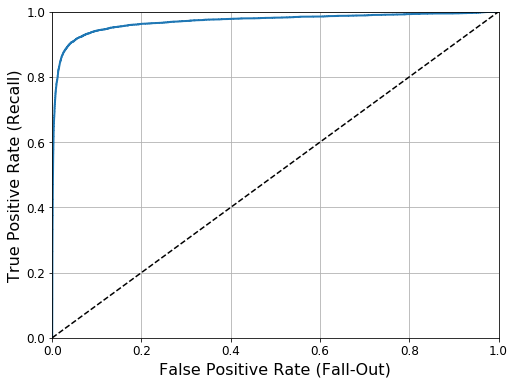

In [37]:
plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)             
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [38]:
roc_auc_score(y_train_5, y_scores)

0.9704522882419195

Compare the results to random forest:

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

In [41]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

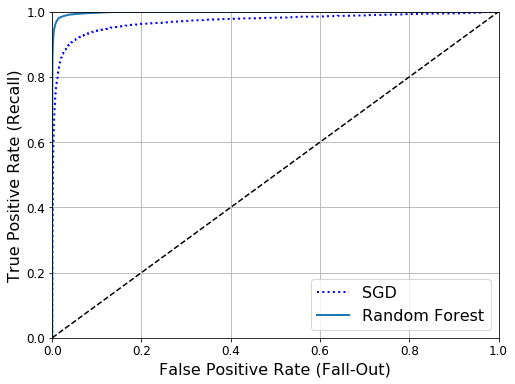

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

You should __prefer the PR curve__ whenever the __positive class is rare__ or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983400347444625

In [44]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [45]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### Multiclass Classification

In [57]:
from sklearn.svm import SVC

In [58]:
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(x_train[:1000], y_train[:1000])
svm_clf.predict([x_train[0]])

array([5], dtype=uint8)

In [59]:
scores = svm_clf.decision_function([x_train[0]])
scores

array([[ 2.77050547,  1.75891031,  5.00689661,  8.28713452, -0.28657772,
         9.29023012,  0.75243068,  4.87252071,  7.2122829 ,  4.93028125]])

In [60]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

One-vs-one and one-vs-rest classifiers can be explicitly used:

- one-vs-one: distinguish 1 & 2, 1 & 3, ... 8 & 9
- one-vs-rest: 1 & all others, 2 & all others...

In [64]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [65]:
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(x_train[:1000], y_train[:1000])
ovr_clf.predict([x_train[0]])

array([3], dtype=uint8)

In [66]:
len(ovr_clf.estimators_)

10

In [67]:
ovo_clf = OneVsOneClassifier(SVC(gamma="auto", random_state=42))
ovo_clf.fit(x_train[:1000], y_train[:1000])
ovo_clf.predict([x_train[0]])

array([5], dtype=uint8)

In [68]:
len(ovo_clf.estimators_)

45

Some classifiers allow multiclass classification as it is:

In [8]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([x_train[0]])

array([5], dtype=uint8)

In [9]:
sgd_clf.decision_function([x_train[0]])

array([[ -5.64829686,  -8.65836146,  -5.0588639 ,  -0.63640619,
        -10.95483472,   1.29309405,  -7.14415425,  -4.34847334,
         -6.51557972,  -6.62932812]])

In [13]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.90905, 0.90645, 0.91525])

In [14]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5697,    2,   32,   20,   18,   59,   39,   15,   38,    3],
       [   2, 6506,   50,   29,    7,   39,   10,   15,   70,   14],
       [  31,   43, 5350,  103,   83,   38,   60,   86,  140,   24],
       [  21,   27,  206, 5405,   10,  200,   28,   65,   97,   72],
       [  13,   17,   28,   17, 5436,   14,   48,   15,   41,  213],
       [  48,   17,   53,  206,   80, 4740,   89,   24,   94,   70],
       [  38,   14,   48,    5,   40,  125, 5619,    4,   22,    3],
       [  18,   19,   69,   17,   87,   13,    3, 5844,   13,  182],
       [  47,  110,  114,  216,   66,  263,   57,   36, 4808,  134],
       [  30,   15,   23,  114,  219,   61,    1,  227,   49, 5210]],
      dtype=int64)

In [37]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

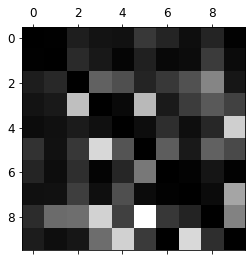

In [38]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [40]:
def my_plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

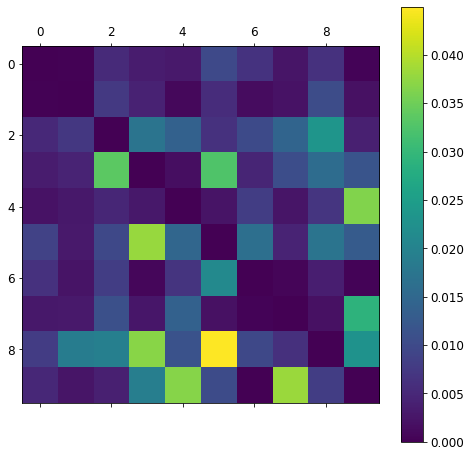

In [41]:
my_plot_confusion_matrix(norm_conf_mx)

In [1]:
from sklearn.metrics import plot_confusion_matrix

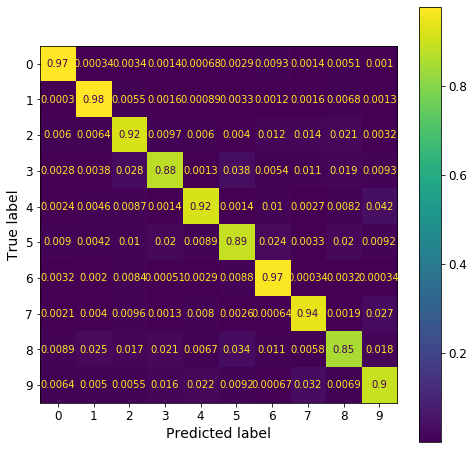

In [42]:
plot_confusion_matrix(sgd_clf, x_train, y_train, normalize='true').figure_.set_size_inches(8, 8)

### Multilabel Classification

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [9]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [10]:
knn_clf.predict([x_train[0]])

array([[False,  True]])

In [11]:
y_pred = knn_clf.predict(x_train[:1000])
f1_score(y_multilabel[:1000], y_pred, average="macro")

0.9855955572760597

Rank-aware metrics: 
- MRR: Mean Reciprocal Rank
- MAP: Mean Average Precision
- NDCG: Normalized Discounted Cumulative Gain

MRR: Where is the first relevant item? This method is simple to compute and is easy to interpret.  It focuses on a single item from the list.

<img src="https://miro.medium.com/max/1286/1*dR24Drmb9J5BLZp8ffjOGA.png" width="400">

MAP: 

<img src="https://miro.medium.com/max/1400/1*0xdZ-NWJLlf3m4oyjh0K5g.png" width="500" height="300">